In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from collections import Counter
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='white')

# Load, format, and regress data

## Load monkey spikes and RL values, then use regression to decode values from spikes

In [2]:
def clean_paired_array_lists(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Input lists must be of equal length.")
    
    # Step 1: Remove pairs where list1 has NaNs
    filtered_pairs = [(a1, a2) for a1, a2 in zip(list1, list2) if not np.isnan(a1).any()]
    
    if not filtered_pairs:
        return [], []

    # Step 2: Find the most common shape in list1 after filtering NaNs
    shapes = [a1.shape for a1, _ in filtered_pairs]
    most_common_shape = Counter(shapes).most_common(1)[0][0]

    # Step 3: Keep only pairs where a1 has the most common shape
    cleaned_list1 = [a1 for a1, a2 in filtered_pairs if a1.shape == most_common_shape]
    cleaned_list2 = [a2 for a1, a2 in filtered_pairs if a1.shape == most_common_shape]

    return np.array(cleaned_list1), np.array(cleaned_list2)

In [3]:
def regress_spikes_values():
    dfs = []
    variables = ['DeltaV_Stim', 'DeltaV_Act', 'DV_left', 'DV_right', 'omega']
    columns = ['monkey', 'session', 'block', 'trial'].extend(variables)
    regression_dict = {}
    for monkey in ['V', 'W']:
        regression_dict[monkey] = {}
        for session in range(4):
            regression_dict[monkey][session] = {}
            for variable in variables:
                print(monkey, session, variable)
                X = []
                Y = []
                for block in range(1,25):
                    for trial in range(1, 81):
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        try:
                            x = np.load(f"data/emp/{file}_spikes_choice.npz")['spikes']
                            y = pd.read_pickle(f'data/rl/{file}_values.pkl')[variable].to_numpy()
                            X.append(x)
                            Y.append(y)
                        except:
                            pass
                X, Y = clean_paired_array_lists(X, Y)
                pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
                pipeline.fit(X, Y)
                regression_dict[monkey][session][variable] = pipeline
                scoring = make_scorer(mean_squared_error, greater_is_better=False)
                cv_scores = cross_val_score(pipeline, X, Y, cv=10, scoring=scoring)

    predictions = []
    for monkey in ['V', 'W']:
        for session in range(4):
            for block in range(1, 25):
                for trial in range(1, 81):
                    row = {'monkey': monkey, 'session': session, 'block': block, 'trial': trial}
                    try:
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        x = np.load(f"data/emp/{file}_spikes_choice.npz")['spikes']
                        for variable in variables:
                            model = regression_dict.get(monkey, {}).get(session, {}).get(variable)
                            if model is not None:
                                y_pred = model.predict([x])[0]
                                row[variable] = y_pred
                            else:
                                row[variable] = np.nan
                        predictions.append(row)
                    except Exception:
                        pass

    monkey_values = pd.DataFrame(predictions)
    monkey_values = monkey_values.sort_values(['monkey', 'session', 'block', 'trial']).reset_index(drop=True)

    return monkey_values

In [28]:
# monkey_values = regress_spikes_values()
# monkey_values['model_type'] = 'monkey'
# monkey_values.to_pickle("data/monkey_values.pkl")
monkey_values = pd.read_pickle("data/monkey_values.pkl")

## Load RL values

In [29]:
def load_rl_values():
    dfs = []
    variables = ['DeltaV_Stim', 'DeltaV_Act', 'DV_left', 'DV_right', 'omega', 'choseBetterStim', 'choseBetterAct']
    columns = ['monkey', 'session', 'block', 'trial'] + variables
    regression_dict = {}
    for monkey in ['V', 'W']:
        for session in range(4):
            for block in range(1,25):
                for trial in range(1, 81):
                    file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                    try:
                        values = pd.read_pickle(f'data/rl/{file}_values.pkl')
                        cols = [monkey, session, block, trial]
                        for var in variables:
                            cols.append(values[var].values[0])
                        dfs.append(pd.DataFrame([cols], columns=columns))
                    except:
                        pass
    rl_values = pd.concat(dfs, ignore_index=True)
    return rl_values

In [30]:
rl_values = load_rl_values()

## Add accuracy and reversal information to RL and monkey dataframes

In [31]:
emp = pd.read_pickle("data/empirical.pkl").copy()
# emp['pre'] = np.where(emp['trial'] < emp['reversal_at_trial'], emp['trial'], None)
# emp['post'] = np.where(emp['trial'] >= emp['reversal_at_trial'], emp['trial'] - emp['reversal_at_trial'], None)
emp['trial_rev'] = emp['trial'].astype('int64') - emp['reversal_at_trial'].astype('int64')
# emp['pre'] = emp['pre'].fillna(-1).infer_objects(copy=False)
# emp['post'] = emp['post'].fillna(-1).infer_objects(copy=False)
# emp['model_type'] = 'monkey'
emp.rename(columns={'monkey_choice': 'cloc'}, inplace=True)
emp.rename(columns={'monkey_accuracy': 'acc'}, inplace=True)
emp.rename(columns={'reward': 'rew'}, inplace=True)
emp['rew'] = emp['rew'].replace(0, -1)
emp['cloc'] = emp['cloc'].replace('left', 0)
emp['cloc'] = emp['cloc'].replace('right', 1)
# emp = emp.drop(columns=['left', 'right', 'correct', 'reversal_at_trial'])

monkey_merged = pd.merge(
    monkey_values,
    emp[["monkey", "session", "block", "trial", "block_type", "rew", "cloc", "clet", "acc", "trial_rev"]],  # only bring desired columns
    on=["monkey", "session", "block", "trial"],
    how="left"  # keeps all df1 rows, fills missing df2 values with NaN
)
monkey_values = monkey_merged.dropna().reset_index(drop=True)

# rl_values['pre'] = emp['pre']
# rl_values['post'] = emp['post']
rl_values['trial_rev'] = emp['trial_rev']
rl_values['block_type'] = emp['block_type']
rl_values['acc'] = np.where(
    ((rl_values['choseBetterStim'] == 1) & (rl_values['block'] <= 12)) | 
    ((rl_values['choseBetterAct'] == 1) & (rl_values['block'] > 12)),
    1,0)
rl_values['model_type'] = 'rl'

/tmp/ipykernel_1717366/3369925473.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  emp['cloc'] = emp['cloc'].replace('right', 1)


## Load NEF values

In [68]:
def load_nef_values(load=False, monkeys=['V', 'W'], sessions=range(4), blocks=range(1,25)):
    if load:
        nef_values = pd.read_pickle("data/nef_values.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        nef_dfs = []
        rl_dfs = []
        for monkey in monkeys:
            for session in sessions:
                for block in blocks:
                    try:
                        file = f"monkey{monkey}_session{session}_block{block}"
                        nef_dfs.append(pd.read_pickle(f'data/nef/{file}_values.pkl').query("perturb==0.0"))
                    except:
                        pass
        nef_values = pd.concat(nef_dfs, ignore_index=True)
        nef_values.to_pickle("data/nef_values.pkl")
    return nef_values

In [69]:
nef_values = load_nef_values(False)
nef_values['model_type'] = 'nef'
nef_values.rename(columns={'w': 'omega'}, inplace=True)

# Plot learning trajectories

In [48]:
def smooth_split(df, y, ylabel, window=5):
    # Split the group into two parts
    left = df[df['trial_rev'] < 0].copy()
    right = df[df['trial_rev'] >= 0].copy()

    # Apply smoothing to each side independently
    left[ylabel] = (left[y].rolling(window=window, center=True, min_periods=1).mean())
    right[ylabel] = (right[y].rolling(window=window, center=True, min_periods=1).mean())

    # Combine back, preserving original order
    return pd.concat([left, right]).sort_index()

In [76]:
def plot_dynamics(monkey, rl, nef, y, xlim=[-40,40], ylim=[0,1], yticks=5):
    rl = rl.sort_values(['monkey', 'session', 'block', 'trial'])
    rl[f'{y}_smooth'] = (
        rl.groupby(['monkey', 'session', 'block'], group_keys=False)
        .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])

    nef = nef.sort_values(['monkey', 'session', 'block', 'trial'])
    nef[f'{y}_smooth'] = (
        nef.groupby(['monkey', 'session', 'block'], group_keys=False)
        .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])

    monkey = monkey.sort_values(['monkey', 'session', 'block', 'trial'])
    monkey[f'{y}_smooth'] = (
        monkey.groupby(['monkey', 'session', 'block'], group_keys=False)
        .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])

    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(12, 4))
    sns.lineplot(rl, x='trial_rev', y=f'{y}_smooth', hue='block_type', style='monkey',
                palette=[palette[3], palette[0]], ax=axes[0],
                hue_order=['what', 'where'], style_order=['V', 'W'])
    sns.lineplot(nef, x='trial_rev', y=f'{y}_smooth', hue='block_type', style='monkey',
                palette=[palette[3], palette[0]], ax=axes[1],
                hue_order=['what', 'where'], style_order=['V', 'W'])
    sns.lineplot(monkey, x='trial_rev', y=f'{y}_smooth', hue='block_type', style='monkey',
                palette=[palette[3], palette[0]], ax=axes[2],
                hue_order=['what', 'where'], style_order=['V', 'W'])
    # axes[0].set(ylabel='P(Better)', xlabel='Trial', title='RL',  ylim=(0,1))
    axes[0].set(ylabel=y, xlabel='Trial', title='RL', xlim=xlim, ylim=ylim, yticks=np.linspace(ylim[0], ylim[1], yticks))
    axes[1].set(xlabel='Trial', title='NEF')
    axes[2].set(xlabel='Trial', title='Monkey')
    axes[0].axhline(0.5, ls=':', color='k')
    axes[1].axhline(0.5, ls=':', color='k')
    axes[2].axhline(0.5, ls=':', color='k')
    axes[0].axvline(0, ls=':', color='k')
    axes[1].axvline(0, ls=':', color='k')
    axes[2].axvline(0, ls=':', color='k')
    axes[0].get_legend().remove()
    plt.legend(ncol=2)
    fig.tight_layout()
    plt.show()

/tmp/ipykernel_1717366/1756435841.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])
/tmp/ipykernel_1717366/1756435841.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])
/tmp/ipykernel_1717366/1756435841.py:15: DeprecationWarning: DataFrameGroupBy.apply

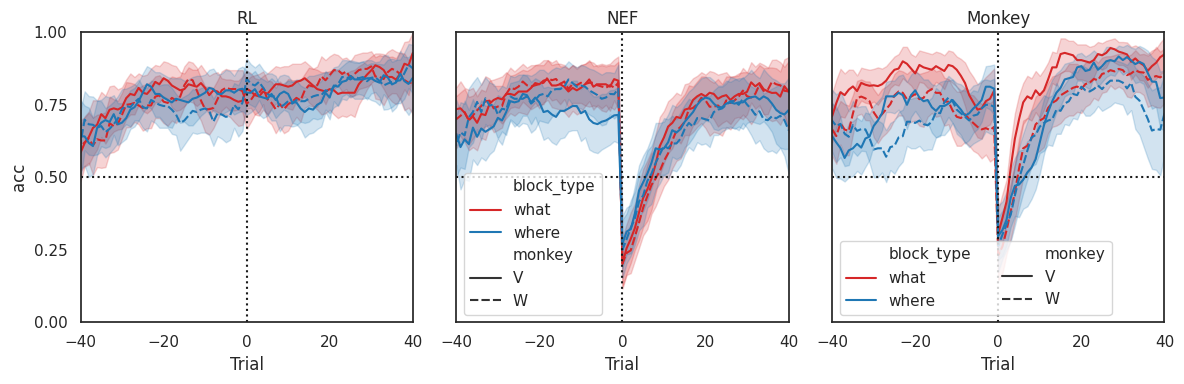

In [72]:
plot_dynamics(monkey_values, rl_values, nef_values, y='acc', xlim=[-40,40])

/tmp/ipykernel_1717366/3901553137.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])
/tmp/ipykernel_1717366/3901553137.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g, y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth'])
/tmp/ipykernel_1717366/3901553137.py:15: DeprecationWarning: DataFrameGroupBy.apply

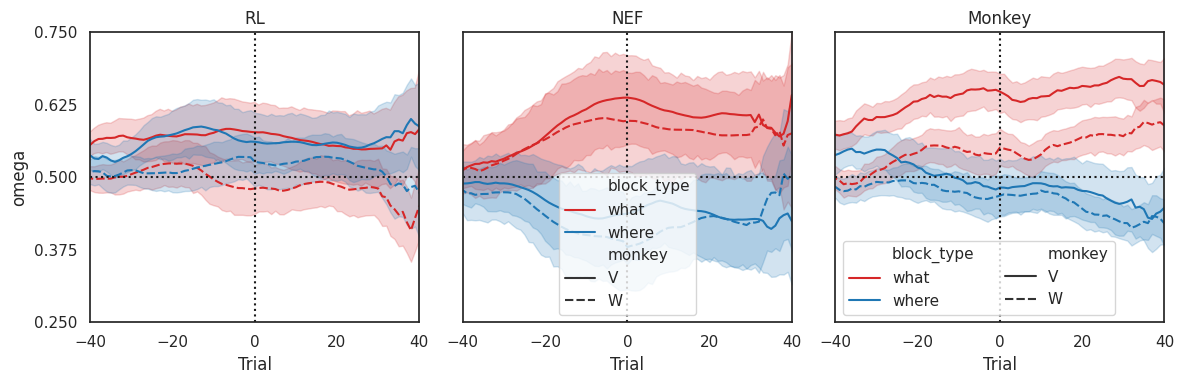

In [77]:
plot_dynamics(monkey_values, rl_values, nef_values, y='omega', xlim=[-40,40], ylim=[0.25, 0.75])

# Plot Omega dependence

/tmp/ipykernel_1284312/3793742513.py:10: RuntimeWarning: invalid value encountered in divide
  rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
/tmp/ipykernel_1284312/3793742513.py:11: RuntimeWarning: invalid value encountered in divide
  rl_p_act = rl_dva / (rl_dvs + rl_dva)


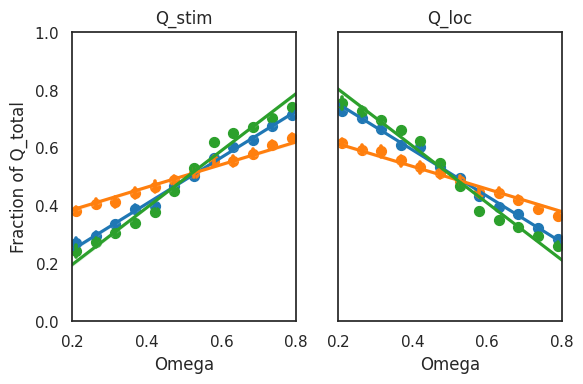

In [184]:
nef_w = nef_values['omega'].to_numpy()
nef_dvs = np.abs(nef_values['va'].to_numpy() - nef_values['vb'].to_numpy())
nef_dva = np.abs(nef_values['vl'].to_numpy() - nef_values['vr'].to_numpy())
nef_p_stim = nef_dvs / (nef_dvs + nef_dva)
nef_p_act = nef_dva / (nef_dvs + nef_dva)

rl_w = rl_values['omega'].to_numpy()
rl_dvs = np.abs(rl_values['DeltaV_Stim'].to_numpy())
rl_dva = np.abs(rl_values['DeltaV_Act'].to_numpy())
rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
rl_p_act = rl_dva / (rl_dvs + rl_dva)

monkey_w = monkey_values['omega'].to_numpy()
monkey_dvs = np.abs(monkey_values['DeltaV_Stim'].to_numpy())
monkey_dva = np.abs(monkey_values['DeltaV_Act'].to_numpy())
monkey_p_stim = monkey_dvs / (monkey_dvs + monkey_dva)
monkey_p_act = monkey_dva / (monkey_dvs + monkey_dva)

w_bins = np.linspace(0, 1, 20)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,4), sharex=True, sharey=True)
sns.regplot(x=rl_w, y=rl_p_stim, x_bins=w_bins, ax=axes[0], color=palette[0], label='RL')
sns.regplot(x=rl_w, y=rl_p_act, x_bins=w_bins, ax=axes[1], color=palette[0], label='RL')
sns.regplot(x=nef_w, y=nef_p_stim, x_bins=w_bins, ax=axes[0], color=palette[1], label='NEF')
sns.regplot(x=nef_w, y=nef_p_act, x_bins=w_bins, ax=axes[1], color=palette[1], label='NEF')
sns.regplot(x=monkey_w, y=monkey_p_stim, x_bins=w_bins, ax=axes[0], color=palette[2], label='Monkey')
sns.regplot(x=monkey_w, y=monkey_p_act, x_bins=w_bins, ax=axes[1], color=palette[2], label='Monkey')
axes[0].set(ylabel="Fraction of Q_total", xlim=(0.2, 0.8), ylim=(0, 1), title="Q_stim", xlabel='Omega')
axes[1].set(xlim=(0.2, 0.8), ylim=(0, 1), title="Q_loc", xlabel='Omega')
plt.tight_layout()